<a href="https://colab.research.google.com/github/Morca97/Lightweight-NAS-A-Comparative-Framework/blob/main/Lightweight_NAS_A_Comparative_Frameworkl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lightweight NAS: A Comparative Framework

# Imports and Initialization

## First package: run, restart and then rerun (Not necessary if CSV files have been already generated)

In [1]:
## Install xautodl package
!pip install xautodl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports and Initialization:

### General Imports (Always Necessary)

In [2]:
## Imports
from google.colab import files
import os
import torch
import numpy as np
import pandas as pd
from scipy import stats
import types
import pickle
from timeit import default_timer as timer

### NATS-Bench + General Imports (Not necessary if CSV files have been already generated)

In [ ]:
## NATs Bench Download
!pip install gdown>=4.4.0
!gdown 17_saCsj_krKjlCBLOJEpNtzPXArMCqxU
!pip install nats_bench

## Extract the benchmarks files of NATS-Bench
!mkdir "nas_bench.torch"
%env TORCH_HOME=/content/nas_bench.torch
!tar xvf /content/NATS-tss-v1_0-3ffb9-simple.tar -C /content/nas_bench.torch/

In [4]:
import torchvision.transforms as transforms
import torch.nn.functional as F    ## For Cross-Entropy Loss Function
from torchvision import datasets as torch_datasets
from timeit import default_timer as timer

In [5]:
## Create the Benchmark Instance:
from nats_bench import create

### ImageNet16-120, Cifar10, Cifar100 (Not necessary if CSV files have been already generated)

In [6]:
## Imports for xautodl Package
from xautodl.datasets.DownsampledImageNet import ImageNet16
from xautodl.models import get_cell_based_tiny_net

In [ ]:
## Install ImageNet16-20
!wget 'https://www.dropbox.com/s/o2fg17ipz57nru1/?dl=1' -O \ImageNet16.tar.gz
!tar xvf /content/ImageNet16.tar.gz -C /content/nas_bench.torch

## Create Folder for CIFAR10 and CIFAR100
!mkdir /content/nas_bench.torch/CIFAR10
!mkdir /content/nas_bench.torch/CIFAR100

In [8]:
## Set up and run on GPUs(After csv files have been generated GPU will not be necessary for experiments)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Transformations to load Images from Cifar10, Cifar100, ImageNet16-120
transform = transforms.Compose(
    [transforms.ToTensor(),
     ])


In [ ]:
## Load dataset from Root Directory
dataset_cifar10 = torch_datasets.CIFAR10(root = "/content/nas_bench.torch/CIFAR10", download = True, transform=transform)
dataset_cifar100 = torch_datasets.CIFAR100(root = "/content/nas_bench.torch/CIFAR100", download = True, transform=transform)
dataset_ImageNet16_120 = ImageNet16('/content/nas_bench.torch/ImageNet16/', True , transform, 120)

### Initialization (Not necessary if CSV files have been already generated)

In [10]:
## Given the Index_Arch and Dataset on which has been elaborated
## Return: tuple with the configuration and the network

def get_network(index, dataset):
  '''
  INPUTS:
   - Index: Index of Architecture 
   - Dataset: Cifar10, Cifar100, ImageNet16-120
  OUTPUTS:
  - config: Dicitonary {"C":, "N":, "arch_str":, "name":, "num_classes":}
  - network: Network Full Structure
  '''
  config = api.get_net_config(index,dataset)    ## Obtain the configuration for the `index`-th architecture on `dataset`.
  network = get_cell_based_tiny_net(config)    ## Representation of the Architecture
  return config, network


# Metrics - Performance Estimation Strategy (Not necessary if CSV files have been already generated)

## ReLU Score

In [11]:
## Function called everytime a ReLU is accessed:
## Provide the Binary Code
def hook(model, input, output):
  output_activation = output.view(output.size(0), -1)     # Collapse the output tensor into a 1-d vector
  output_activation = (output_activation > 0).float()    ## Binary Conversion
  network.binary_code = torch.cat((network.binary_code, output_activation), -1)    ## Concat to obtain the final Binary Code

In [12]:
def get_ReLUScore_per_network(network, data_loader):

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  start = timer()

  network = network.to(device)
  network.binary_code = torch.tensor([])
  network.binary_code = network.binary_code.to(device)

  
  ## Cycle through each layer of the network, attach a hook to the ReLU modules.
  for name,module in network.named_modules():    
    if 'torch.nn.modules.activation.ReLU' in str(type(module)):
      module.register_forward_hook(hook)

  # access to the first batch
  data_iterator = iter(data_loader)
  batch,_ = next(data_iterator)
  batch = batch.to(device)

  ## Pass the Batch to the Network
  network(batch)
  
  ## Obtain the K_H Matrix [128,128] 
  ## Diagonal Elements represent the Binary Code Length
  ## Off-Diagonal Elements are the similarity between binary codes (Binary_code_length - dissimilarity)
  K1 = network.binary_code @ network.binary_code.t()
  K2 = (1.- network.binary_code) @ (1.- network.binary_code.t())
  K = K1 + K2
 
  ## ReLU score
  score = np.linalg.slogdet(K.cpu())[1]

  end = timer()
  time_elapsed = end - start

  return K, score, time_elapsed

## Synflow

In [13]:
def no_op(self,x):
  return x


def get_synflow_per_network(net, data_loader, bn=False):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  start = timer()

  # access to the first batch
  data_iterator = iter(data_loader)
  batch,_ = next(data_iterator)
  batch = batch.to(device)


  ## Avoid Batch Normalization, no transformations applied to the input data
  if bn == False:
    for name,layer in network.named_modules(): 
      if ('torch.nn.modules.batchnorm.BatchNorm2d' in str(type(layer))) or ('torch.nn.modules.batchnorm.BatchNorm1d' in str(type(layer))):
        layer.forward = types.MethodType(no_op,layer)

  #convert weights to their abs.
  with torch.no_grad():
    for name, param in net.state_dict().items():
      param.abs_()    ## in-place abs()


  # The following stack of code calculates the R_(SF) part of the Synflow metric. 
  # The final metric is calculated as:
  #      dR_(SF)/d(theta) * theta
  # for each weight, but we will calculate it more forward in this code. 
  # Finally, and even more forward in the code, we will sum all the metrics for each weight in the network.

  net.zero_grad()    # set gradients to zero
  net.double()    # convert all network parameters to tensor double
  net.to(device)
  input_dim= batch[0][None,:].shape    # get dimension of an image
  inputs = torch.ones(input_dim).double().to(device)    # create a tensor of ones shaped as a batch of one image
  output = net.forward(inputs)    # propagate the tensor of ones through the network and calculate the output
  torch.sum(output[1]).backward()    # calculate the gradient by backpropagating the output; output[1] is to get the actual output

  # Now we have dR_(SF)/d(theta) for each weight in the network. 
  # We now define the function that multiplies this quantity with the weights, so dR_(SF)/d(theta) * theta.
  def synflow(layer):
    if layer.weight.grad is not None:  
      return torch.abs(layer.weight * layer.weight.grad)
    else:
      return torch.zeros_like(layer.weight)

  # Now, we initialize a list that will contain the SF score for every weight.
  metric_array = []

  # We cycle through every layer of the network (Conv2d and Linear), and calculate the score for the layer.
  for name,layer in net.named_modules(): 
    if ('torch.nn.modules.conv.Conv2d' in str(type(layer))) or ('torch.nn.modules.linear.Linear'  in str(type(layer))):
      metric_array.append(synflow(layer).sum())    # we sum the Synflow for each weight in a layer and put it into metric_array list

  metric = torch.stack(metric_array, dim=0).sum(dim=0) # we return only the sum on synflow over all layers
  metric = metric.detach().cpu().numpy().item()    # to get only the number without other info about the network/device

  end = timer()
  time_elapsed = end - start
  return metric,time_elapsed

## Grad_Norm

In [14]:
def get_grad_norm_per_network(net, data_loader,loss_fn=F.cross_entropy,device = device):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  start = timer()
  
  # access to the first batch
  data_iterator = iter(data_loader)
  batch,targets = next(data_iterator)
  batch = batch.to(device)

  net.zero_grad()    # set gradients to zero
  net.to(device)
  outputs = net.forward(batch)    # propagate the input batch through the network and calculate the output
  loss = loss_fn(outputs[1], targets.to(device))    ## Calcuate the Loss function from the output[1] to the ground truth (targets)
  loss.backward()    ## Backpropagation of the Loss


  # The following stack of code calculates the R_(GN) part of the Synflow metric. 
  # The final metric is calculated as:
  #      Euclidean_Norm(dR_(GN)/d(theta))
  # for each weight, but we will calculate it more forward in this code. 
  # Finally, and even more forward in the code, we will sum all the Euclidean Norm of the Gradients in the network.
  
  def grad_norm(layer):
    if layer.weight.grad is not None:  
      return layer.weight.grad.norm()
    else:
      return torch.zeros_like(layer.weight)

  # Now, we initialize a list that will contain the Euclidean norm of the gradients.
  grad_norm_arr = []


  # We cycle through every layer of the network (Conv2d and Linear), and calculate the score for the layer.
  for name,layer in net.named_modules(): 
    if (('torch.nn.modules.conv.Conv2d' in str(type(layer))) or ('torch.nn.modules.linear.Linear' in str(type(layer)))):
      grad_norm_arr.append(grad_norm(layer))    # we put the Grad Norm of each weight into metric_array list

  grad_norm = torch.stack(grad_norm_arr, dim=0).sum(dim=0)    # we return only the sum on grad_norm over all layers
  grad_norm = grad_norm.detach().cpu().numpy().item()    # to get only the number without other info about the network/ device

  end = timer()
  time_elapsed = end - start
  return grad_norm,time_elapsed


# Creating our CSV for Experiments

## Creating and exporting our CSV (Not necessary if CSV files have been already generated)

Now we score all the 15625 architectures of NAS Bench using:
*   validation accuracy (12 epochs)
*   ReLUScore
*   synflow
*   grad_norm

and we save the results in a csv file made as follows:


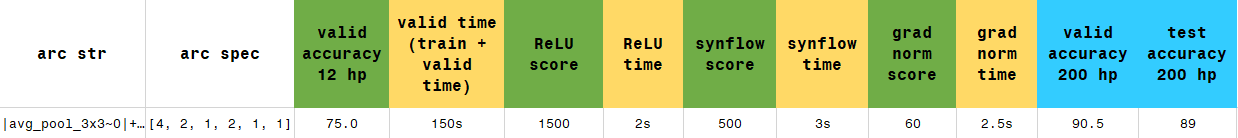

with a row for every architecture. We do this for each of the three datasets: CIFAR10, CIFAR100 and ImageNet16-120.

To create the second column, we need the following function:

In [ ]:
## Represent every architecture as a vector of six elements, where each element is a number from 0 to 4, representing the operations of the network through the following dictionary:
op_to_index = { 
  'none': 0, 
  'skip_connect': 1, 
  'nor_conv_1x1': 2, 
  'nor_conv_3x3': 3, 
  'avg_pool_3x3': 4
}

## Function that generates the vector representation of columnn ´arc spec´ given ´arc str´
def get_spec_from_arch_str(arch_str):
    nodes = arch_str.split('+')
    nodes = [node[1:-1].split('|') for node in nodes]
    nodes = [[op_and_input.split('~')[0]  for op_and_input in node] for node in nodes]

    spec = [op_to_index[op] for node in nodes for op in node]
    return spec

In [ ]:
## Create the API instance for the topology search space in NATS
api = create(None, 'tss', fast_mode=True, verbose=False)

[2022-07-06 05:47:52] Try to use the default NATS-Bench (topology) path from fast_mode=True and path=None.


In [ ]:
## CSV files are generated by concatenating manually generated batches.
batch_start = 0   #4000,8000,12000
batch_end = 4000   # 8000,12000, len(api)

In [ ]:
from tqdm import tqdm

datasets = {"cifar10-valid": dataset_cifar10, "cifar100":dataset_cifar100, "ImageNet16-120": dataset_ImageNet16_120}

examples_list = {"cifar10-valid": [], "cifar100":[], "ImageNet16-120":[]}

for dataset_name, dataset in datasets.items():
  for i in tqdm(range(batch_start, batch_end)):

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=128)
    
    info = api.get_more_info(i, dataset_name, is_random=False, hp='12')
    info_200_ephocs = api.get_more_info(i, dataset_name, is_random=False, hp='200')

    info_for_arch_str, _ = get_network(i,dataset_name)
    arch_str = info_for_arch_str['arch_str']
    arch_spec = get_spec_from_arch_str(arch_str)
    valid_accuracy = info['valid-accuracy']
    validation_time = info['train-all-time'] + info['valid-all-time']
    validation_accuracy_200_epochs = info_200_ephocs['valid-accuracy']
    test_accuracy_200_epochs = info_200_ephocs['test-accuracy']

    _, network = get_network(i,dataset_name)
    _, ReLU_score, ReLU_time = get_ReLUScore_per_network(network, data_loader)
    
    _, network = get_network(i,dataset_name)
    synflow_score, synflow_time = get_synflow_per_network(network, data_loader)

    _, network = get_network(i,dataset_name)
    gradNorm_score, gradNorm_time = get_grad_norm_per_network(network, data_loader)
    
    examples_list[dataset_name].append([arch_str,
                                        arch_spec,
                                        valid_accuracy,
                                        validation_time,
                                        ReLU_score, 
                                        ReLU_time, 
                                        synflow_score, 
                                        synflow_time, 
                                        gradNorm_score, 
                                        gradNorm_time,
                                        validation_accuracy_200_epochs,
                                        test_accuracy_200_epochs])
results_columns = ['arch_str',
                  'arch_spec',
                  'valid_accuracy_12_epochs',
                  'validation_12_epochs_time',
                  'ReLU_score', 
                  'ReLU_time', 
                  'synflow_score', 
                  'synflow_time', 
                  'gradNorm_score', 
                  'gradNorm_time',
                   'validation_accuracy_200_epochs',
                   'test_accuracy_200_epochs']

cifar10_results = pd.DataFrame(examples_list['cifar10-valid'], columns=[results_columns])
cifar100_results = pd.DataFrame(examples_list['cifar100'], columns=[results_columns])
ImageNet16_120_results = pd.DataFrame(examples_list['ImageNet16-120'], columns=[results_columns])


cifar10_results.to_csv(f'cifar10_results_{batch_start}_{batch_end-1}.csv', encoding = 'utf-8-sig')
cifar100_results.to_csv(f'cifar100_results_{batch_start}_{batch_end-1}.csv', encoding = 'utf-8-sig')
ImageNet16_120_results.to_csv(f'ImageNet16_120_results_{batch_start}_{batch_end-1}.csv', encoding = 'utf-8-sig') 

files.download(f'cifar10_results_{batch_start}_{batch_end-1}.csv')
files.download(f'cifar100_results_{batch_start}_{batch_end-1}.csv')
files.download(f'ImageNet16_120_results_{batch_start}_{batch_end-1}.csv')

  4%|▍         | 156/4000 [01:01<20:54,  3.06it/s]

## Generation of the final CSV files for Cifar10, Cifar100 and ImageNet16-120 (Concatenation)

In [ ]:
# Make 3 directories named: cifar10, cifar100, imageNet
!mkdir '/content/cifar10'
!mkdir '/content/cifar100'
!mkdir '/content/imageNet'

!mv 'cifar10_results_0_3999.csv' '/content/cifar10'
!mv 'cifar10_results_4000_7999.csv' '/content/cifar10'
!mv 'cifar10_results_8000_11999.csv' '/content/cifar10'
!mv 'cifar10_results_12000_15624.csv' '/content/cifar10'

!mv 'cifar100_results_0_3999.csv' '/content/cifar100'
!mv 'cifar100_results_4000_7999.csv' '/content/cifar100'
!mv 'cifar100_results_8000_11999.csv' '/content/cifar100'
!mv 'cifar100_results_12000_15624.csv' '/content/cifar100'

!mv 'ImageNet16_120_results_0_3999.csv' '/content/imageNet'
!mv 'ImageNet16_120_results_4000_7999.csv' '/content/imageNet'
!mv 'ImageNet16_120_results_8000_11999.csv' '/content/imageNet'
!mv 'ImageNet16_120_results_12000_15624.csv' '/content/imageNet'

In [ ]:
path = r'/content/cifar10/' 
file_names = os.listdir(path)
all_files = [ path + file_name for file_name in file_names]
all_files

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame_cif10 = pd.concat(li, axis=0, ignore_index=True)
del frame_cif10["Unnamed: 0"]

In [ ]:
path = r'/content/cifar100/' 
file_names = os.listdir(path)
all_files = [ path + file_name for file_name in file_names]
all_files

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame_cif100 = pd.concat(li, axis=0, ignore_index=True)
del frame_cif100["Unnamed: 0"]

In [ ]:
path = r'/content/imageNet/' 
file_names = os.listdir(path)
all_files = [ path + file_name for file_name in file_names]
all_files

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame_imageNet = pd.concat(li, axis=0, ignore_index=True)
del frame_imageNet["Unnamed: 0"]

In [ ]:
frame_cif10.to_csv('cifar10_results.csv', encoding = 'utf-8-sig')
frame_cif100.to_csv('cifar100_results.csv', encoding = 'utf-8-sig')
frame_imageNet.to_csv('ImageNet16_120_results.csv', encoding = 'utf-8-sig') 

In [ ]:
files.download('cifar10_results.csv')
files.download('cifar100_results.csv')
files.download('ImageNet16_120_results.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Load CSV  
If CSV files are already loaded in the Colab File System Root

In [7]:
cifar10_results_csv = pd.read_csv(r'/content/cifar10_results.csv', index_col=0)
cifar100_results_csv = pd.read_csv(r'/content/cifar100_results.csv', index_col=0)
ImageNet16_120_results_csv = pd.read_csv(r'/content/ImageNet16_120_results.csv', index_col=0)

## Convert second column of each dataframe to list
cifar10_results_csv['arch_spec'] = cifar10_results_csv['arch_spec'].apply(lambda x: [int(y) for y in x[1:-1].split(",")])
cifar100_results_csv['arch_spec'] = cifar100_results_csv['arch_spec'].apply(lambda x: [int(y) for y in x[1:-1].split(",")])
ImageNet16_120_results_csv['arch_spec'] = ImageNet16_120_results_csv['arch_spec'].apply(lambda x: [int(y) for y in x[1:-1].split(",")])

In [8]:
datasets_dic = {'cifar10': cifar10_results_csv, 'cifar100': cifar100_results_csv, 'ImageNet16-120': ImageNet16_120_results_csv}
metricName_dic = {'valid_accuracy_12_epochs': ['valid_accuracy_12_epochs', 'validation_12_epochs_time'], 
                   'ReLU_score': ['ReLU_score', 'ReLU_time'], 
                   'synflow_score': ['synflow_score', 'synflow_time'], 
                   'gradNorm_score': ['gradNorm_score','gradNorm_time']}

# Search Strategy

## Random Search

In [ ]:
def run_random_search(dataset, metric, n=1000, N=30):
  '''
  INPUTS: 
    - dataset: PandasDataframe created from the csv contening the results
    - metric: { valid_accuracy_12_epochs, ReLU_score, synflow_score, gradNorm_score}
    - n: number of architectures in the sample
    - N: number of experiments

  OUTPUT: valid200_mean, valid200_std, ,test200_mean, test200_std, test_accuracy_200_epochs (list of lists [N,n] with test accuracy progress during the experiment), experiments time mean
  '''
  validation_accuracies, test_accuracies, test_accuracies_progress_experiments, time_experiments = [], [], [], []
  for experiment in range(N): 
    start = timer()
    population = dataset.sample(n=n, replace=False)    ##shufflling the dataset and keep a sample of n architectures 
    population.reset_index(inplace=True, drop=True)    ##keep increasing index
    best_score, best_validation_200, best_test_200, time_count = -1, -1, [0.0], 0
    for i in range(len(population)):
      new_score, validation_accuracy, test_accuracy, time = population.loc[i, [metricName_dic[metric][0], 'validation_accuracy_200_epochs', 'test_accuracy_200_epochs', metricName_dic[metric][1]]]
      if new_score > best_score:
        best_score = new_score
        best_validation_200 = validation_accuracy
        best_test_200.append(float(test_accuracy))
      else:
        best_test_200.append(best_test_200[-1])
      time_count += time
    end = timer()
    time_count += (end - start)

    best_test_200.pop(0)    ## remove the inizialization value (0.0)
    validation_accuracies.append(best_validation_200)    ## save the best validation accuracy value that is obtained in the experiment
    test_accuracies.append(best_test_200[-1])    ## save the best test accuracy value that is obtained in the experiment
    test_accuracies_progress_experiments.append(best_test_200)    ## save the test accuracy progress of the experiment (it is useful for making the progrsess graph) 
    time_experiments.append(time_count)
    
  return np.mean(validation_accuracies), np.std(validation_accuracies), np.mean(test_accuracies), np.std(test_accuracies), test_accuracies_progress_experiments, np.mean(time_experiments)

## Aging Evolutionary

**Mutation Function**. <br>
It takes a vector of an architecture as input, and then it selects a random element and changes it to another operation. So, for ex. [2 3 4 **2** 4 1] becomes [2 3 4 **0** 4 1].

In [ ]:
import random
import copy
random.seed = 42   

def mutate_spec(old_spec):
  idx_to_change = random.randrange(len(old_spec))
  entry_to_change = old_spec[idx_to_change]
  possible_entries = [x for x in range(5) if x != entry_to_change]
  new_entry = random.choice(possible_entries)
  new_spec = copy.copy(old_spec)
  new_spec[idx_to_change] = new_entry
  return new_spec

The following function selects a random population of architectures (their string version, not the vector one) to initialize the evolutionary algorithm.

In [ ]:
def random_combination(iterable, sample_size):
  pool = tuple(iterable)
  n = len(pool)
  indices = sorted(random.sample(range(n), sample_size))
  return tuple(pool[i] for i in indices)

The evolution function follows:

In [ ]:
from pandas.core.common import random_state
def evolution_search(dataset,metric, max_trained_models=1000, pool_size=64, tournament_size=10): 
  start = timer()   
  best_valids_200, best_tests_200, time_score = [0.0], [0.0], 0
  pool = []   # (metric, validation200, spec) tuples
  num_trained_models = 0

  # create randomly the initial population
  population = dataset.sample(n=pool_size, replace=False) # shufflling the dataset and keep a sample of n architectures 
  population.reset_index(inplace=True, drop=True) # keep increasing index
  pool = list(population[[metricName_dic[metric][0], 'validation_accuracy_200_epochs', 'arch_spec', 'test_accuracy_200_epochs', metricName_dic[metric][1]]].itertuples(index=False, name=None)) # update pool to respect the definition of list of tuples
  
  # find the best Validation accuracy among the initial population relative to the Highest score
  max_metric, max_val_200, max_test_200 = -1.0, -1.0, -1.0
  for score, valid_200, arch_spec, test_acc_200, time in pool:
    if score > max_metric:
      max_val_200, max_metric, max_test_200 = valid_200, score, test_acc_200
    time_score += time

  best_valids_200.append(max_val_200)
  best_tests_200.append(max_test_200)
  num_trained_models += 1

  # After the pool is seeded, proceed with evolving the population.
  while(num_trained_models < max_trained_models):
   
    sample = random_combination(pool, tournament_size)    ## Sub-Population Generation
    best_spec = sorted(sample, key=lambda i:i[0])[-1][2]    ## Best Arch_spec of the Architecure with Highest Score

    new_spec = mutate_spec(best_spec)    ## Mutation    
    num_trained_models += 1

    child = dataset[dataset['arch_spec'].apply(lambda x: str(x))==str(new_spec)] # find the child architecture in the original dataset and get it
    child = list(child[[metricName_dic[metric][0], 'validation_accuracy_200_epochs','arch_spec', 'test_accuracy_200_epochs', metricName_dic[metric][1]]].itertuples(index=False, name=None)) # new(metric, validation200, spec, test200, time for metric) tuple for the child
 
    pool.append(child[0]) # append child tuple to the pool list of tuples
    
    pool.pop(0) # kill oldest Architecture in population

    new_metric, new_validation_200, new_spec, new_test_200, time = child[0]

    if new_metric > max_metric:
      max_metric = new_metric
      best_valids_200.append(new_validation_200) 
      best_tests_200.append(new_test_200)
    else: 
      best_valids_200.append(best_valids_200[-1])
      best_tests_200.append(best_tests_200[-1])
    time_score += time
  end = timer()

  best_valids_200.pop(0)    ## remove the inizialization value (0.0)
  best_tests_200.pop(0)    ## remove the inizialization value (0.0)
  
  time_experiment = time_score + (end - start)
  return best_valids_200[-1], best_tests_200[-1], best_tests_200, time_experiment

In [ ]:
def run_evolution_search(dataset, metric, max_trained_models=1000, pool_size=64, tournament_size=10, N=30):
  '''
  INPUTS: 
    - dataset: PandasDataframe created from the csv contening the results
    - metric: { valid_accuracy_12_epochs, ReLU_score, synflow_score, gradNorm_score}
    - pool_size: number of architectures in the population 
    - max_trained_models: number of mutation
    - tournament_size: number of architectures in the sample 
    - N: number of experiments

  OUTPUT: valid200_mean, valid200_std, ,test200_mean, test200_std, test_accuracy_200_epochs (list of lists [N,n] with progress of test accuracy during the experiment), experiments time mean
  '''
  validation_accuracies, test_accuracies, test_accuracies_progress_experiments, time_experiments = [], [], [], []
  for experiment in range(N):  
    val200, test200, tests_accuracy_200_progress, time_exp = evolution_search(dataset,metric,max_trained_models, pool_size, tournament_size)

    validation_accuracies.append(val200)    ## save the best validation accuracy value that is obtained in the experiment
    test_accuracies.append(test200)    ## save the best test accuracy value that is obtained in the experiment
    test_accuracies_progress_experiments.append(tests_accuracy_200_progress)    ## save the test accuracy progress of the experiment (it is useful for making the progrsess graph)
    time_experiments.append(time_exp)
    
  return np.mean(validation_accuracies), np.std(validation_accuracies), np.mean(test_accuracies), np.std(test_accuracies), test_accuracies_progress_experiments, np.mean(time_experiments)

# Experiments and Plots

## Plot Imports

In [15]:
!pip install colorspacious

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
from matplotlib import pyplot as plt
import IPython.display as ipd
from colorspacious import cspace_converter

## Matrix correlation:
Sample networks at random and plot the obtained scores on the untrained networks against their validation-accuracies when trained.
(This block of code require running: NATS-bench, Cifar10, Inizialization, ReLU, Score)

In [ ]:
## Create the API instance for the topology search space in NATS
api = create(None, 'tss', fast_mode=True, verbose=False)    
data_loader_grap = torch.utils.data.DataLoader(dataset_cifar10, batch_size=128)

[2022-07-07 19:57:22] Try to use the default NATS-Bench (topology) path from fast_mode=True and path=None.


In [ ]:
Ks_ac_0_60, Ks_ac_60_70, Ks_ac_70_80, Ks_ac_80_90, Ks_ac_90_100 = [], [], [], [], []
dataset = "cifar10-valid"
for i in range(500, len(api)):
  info_200_ephocs = api.get_more_info(i, dataset, is_random=False, hp='200')
  val_acc_200_hp = info_200_ephocs['valid-accuracy']
  if len(Ks_ac_0_60)<5 and val_acc_200_hp > 10 and val_acc_200_hp < 60:
    _, network = get_network(i, dataset)
    Ks, _, _ = get_ReLUScore_per_network(network, data_loader_grap)
    Ks_ac_0_60.append(Ks)
  elif len(Ks_ac_60_70)<5 and val_acc_200_hp >= 60 and val_acc_200_hp < 70:
    _, network = get_network(i, dataset)
    Ks, _, _ = get_ReLUScore_per_network(network, data_loader_grap)
    Ks_ac_60_70.append(Ks)
  elif len(Ks_ac_70_80)<5 and val_acc_200_hp >= 70 and val_acc_200_hp < 80:
    _, network = get_network(i, dataset)
    Ks, _, _ = get_ReLUScore_per_network(network, data_loader_grap)
    Ks_ac_70_80.append(Ks)
  elif len(Ks_ac_80_90)<5 and val_acc_200_hp >= 80 and val_acc_200_hp < 90:
    _, network = get_network(i, dataset)
    Ks, _, _ = get_ReLUScore_per_network(network, data_loader_grap)
    Ks_ac_80_90.append(Ks)
  elif len(Ks_ac_90_100)<5 and val_acc_200_hp >= 90:
    _, network = get_network(i, dataset)
    Ks, _, _ = get_ReLUScore_per_network(network, data_loader_grap)
    Ks_ac_90_100.append(Ks)
  if len(Ks_ac_0_60)>=5 and len(Ks_ac_60_70)>=5 and len(Ks_ac_70_80)>=5 and len(Ks_ac_80_90)>=5 and len(Ks_ac_90_100)>=5:
    break
Ks_list = [Ks_ac_0_60, Ks_ac_60_70, Ks_ac_70_80, Ks_ac_80_90, Ks_ac_90_100]

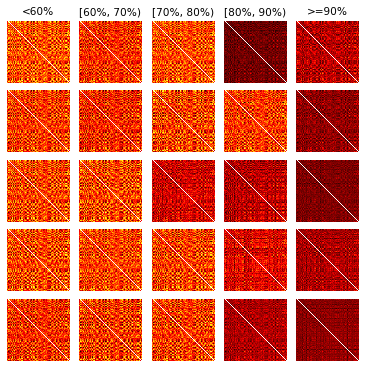

In [ ]:
size_tit = 10.5
fig, ax = plt.subplots(len(Ks_list),len(Ks_list[0]), figsize=(5,5), constrained_layout=True)
for i, Ks in enumerate(Ks_list):
  for j, K in enumerate(Ks):
    if j==0:
      if i==0:
        ax[j][i].set_title('<60%', size=size_tit)
      elif i==1:
        ax[j][i].set_title('[60%, 70%)', size=size_tit)
      elif i==2:
        ax[j][i].set_title('[70%, 80%)', size=size_tit)
      elif i==3:
        ax[j][i].set_title('[80%, 90%)', size=size_tit)
      elif i==4:
        ax[j][i].set_title('>=90%', size=size_tit)     
    ax[j][i].imshow(K.cpu(), cmap='hot', interpolation='nearest')
    ax[j][i].axis('off')
plt.savefig("sim_mats.svg", format='svg')

In [ ]:
# download progress graphs
files.download('/content/sim_mats.svg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Scatter Plot
This block of code require only load csv files

In [ ]:
title_size = 16
label_size = 14
tick_size = 13
xlabel = 'Validation accuracy'
figure_size = (17,4.5) 
w_space = 0.35 

### Valid Accuracy 12 hp 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


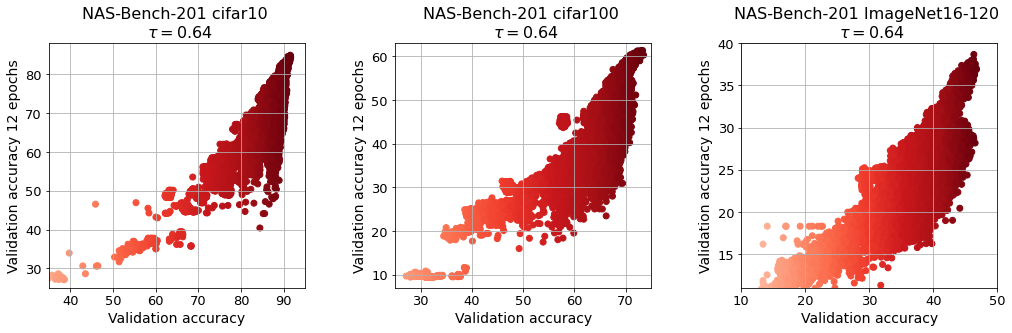

In [ ]:
ylabel = "Validation accuracy 12 epochs"
color_map = plt.get_cmap('Reds')
tau_cif10, _ = stats.kendalltau(cifar10_results_csv['valid_accuracy_12_epochs'], cifar10_results_csv['test_accuracy_200_epochs'])
tau_cif100, _ = stats.kendalltau(cifar100_results_csv['valid_accuracy_12_epochs'], cifar100_results_csv['test_accuracy_200_epochs'])
tau_ImNet, _ = stats.kendalltau(ImageNet16_120_results_csv['valid_accuracy_12_epochs'], ImageNet16_120_results_csv['test_accuracy_200_epochs'])


fig, ax = plt.subplots(1,3, figsize=figure_size, constrained_layout=True)
ax[0].scatter(cifar10_results_csv['validation_accuracy_200_epochs'], cifar10_results_csv['valid_accuracy_12_epochs'], c=cifar10_results_csv['validation_accuracy_200_epochs'], cmap=color_map, rasterized=True)
ax[0].set_xlim([35, 95])
ax[0].set_ylim([25, 88])
ax[0].set_title(f"NAS-Bench-201 cifar10 \n $\\tau=${tau_cif10:.2f}", size=title_size)
ax[0].set_xlabel(xlabel, size=label_size)
ax[0].set_ylabel(ylabel, size=label_size)
ax[0].tick_params(axis='both', labelsize=tick_size)
ax[0].grid()

ax[1].scatter(cifar100_results_csv['validation_accuracy_200_epochs'], cifar100_results_csv['valid_accuracy_12_epochs'], c=cifar100_results_csv['validation_accuracy_200_epochs'], cmap=color_map, rasterized=True)
ax[1].set_xlim([25, 75])
ax[1].set_ylim([7, 63])
ax[1].set_title(f"NAS-Bench-201 cifar100 \n $\\tau=${tau_cif100:.2f}", size=title_size)
ax[1].set_xlabel(xlabel, size=label_size)
ax[1].set_ylabel(ylabel, size=label_size)
ax[1].tick_params(axis='both', labelsize=tick_size)
ax[1].grid()

ax[2].scatter(ImageNet16_120_results_csv['validation_accuracy_200_epochs'], ImageNet16_120_results_csv['valid_accuracy_12_epochs'], c=ImageNet16_120_results_csv['validation_accuracy_200_epochs'], cmap=color_map, rasterized=True)
ax[2].set_xlim([10, 50])
ax[2].set_ylim([11, 40])
ax[2].set_title(f"NAS-Bench-201 ImageNet16-120 \n $\\tau=${tau_ImNet:.2f}", size=title_size)
ax[2].set_xlabel(xlabel, size=label_size)
ax[2].set_ylabel(ylabel, size=label_size)
ax[2].tick_params(axis='both', labelsize=tick_size)
ax[2].grid()
plt.subplots_adjust(wspace=w_space)
plt.savefig("scatter_valid12.svg", format='svg', dpi=650)

In [ ]:
# download graph
files.download('/content/scatter_valid12.svg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### ReLU Score

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


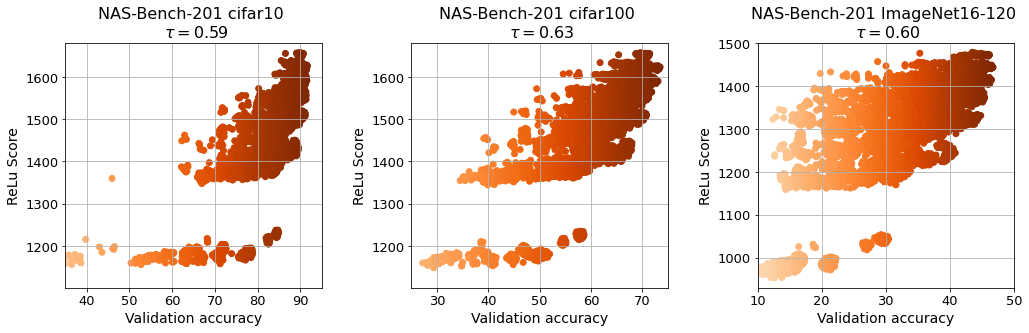

In [ ]:
ylabel = "ReLu Score"
color_map = plt.get_cmap('Oranges')
tau_cif10, _ = stats.kendalltau(cifar10_results_csv['ReLU_score'], cifar10_results_csv['test_accuracy_200_epochs'])
tau_cif100, _ = stats.kendalltau(cifar100_results_csv['ReLU_score'], cifar100_results_csv['test_accuracy_200_epochs'])
tau_ImNet, _ = stats.kendalltau(ImageNet16_120_results_csv['ReLU_score'], ImageNet16_120_results_csv['test_accuracy_200_epochs'])

fig, ax = plt.subplots(1,3, figsize=figure_size, constrained_layout=True)
ax[0].scatter(cifar10_results_csv['validation_accuracy_200_epochs'], cifar10_results_csv['ReLU_score'], c=cifar10_results_csv['validation_accuracy_200_epochs'], cmap=color_map, rasterized=True)
ax[0].set_xlim([35, 95])
ax[0].set_ylim([1101, 1680])
ax[0].set_title(f"NAS-Bench-201 cifar10 \n $\\tau=${tau_cif10:.2f}", size=title_size)
ax[0].set_xlabel(xlabel, size=label_size)
ax[0].set_ylabel(ylabel, size=label_size)
ax[0].tick_params(axis='both', labelsize=tick_size)
ax[0].grid()

ax[1].scatter(cifar100_results_csv['validation_accuracy_200_epochs'], cifar100_results_csv['ReLU_score'], c=cifar100_results_csv['validation_accuracy_200_epochs'], cmap=color_map, rasterized=True)
ax[1].set_xlim([25, 75])
ax[1].set_ylim([1101, 1680])
ax[1].set_title(f"NAS-Bench-201 cifar100 \n $\\tau=${tau_cif100:.2f}", size=title_size)
ax[1].set_xlabel(xlabel, size=label_size)
ax[1].set_ylabel(ylabel, size=label_size)
ax[1].tick_params(axis='both', labelsize=tick_size)
ax[1].grid()

ax[2].scatter(ImageNet16_120_results_csv['validation_accuracy_200_epochs'], ImageNet16_120_results_csv['ReLU_score'], c=ImageNet16_120_results_csv['validation_accuracy_200_epochs'], cmap=color_map, rasterized=True)
ax[2].set_xlim([10, 50])
ax[2].set_ylim([930, 1500])
ax[2].set_title(f"NAS-Bench-201 ImageNet16-120 \n $\\tau=${tau_ImNet:.2f}", size=title_size)
ax[2].set_xlabel(xlabel, size=label_size)
ax[2].set_ylabel(ylabel, size=label_size)
ax[2].tick_params(axis='both', labelsize=tick_size)
ax[2].grid()

plt.subplots_adjust(wspace=w_space)
plt.savefig("scatter_ReLUScore.svg", format='svg', dpi=570)

In [ ]:
# download graph
files.download('/content/scatter_ReLUScore.svg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Synflow

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


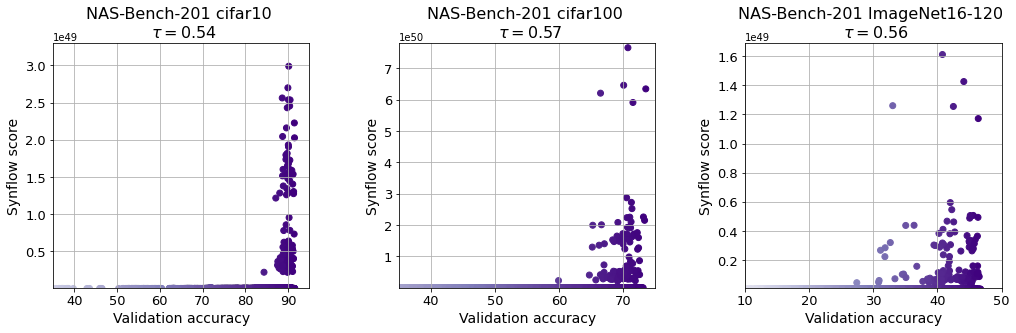

In [ ]:
ylabel = "Synflow score"
color_map = plt.get_cmap('Purples')
tau_cif10, _ = stats.kendalltau(cifar10_results_csv['synflow_score'], cifar10_results_csv['test_accuracy_200_epochs'])
tau_cif100, _ = stats.kendalltau(cifar100_results_csv['synflow_score'], cifar100_results_csv['test_accuracy_200_epochs'])
tau_ImNet, _ = stats.kendalltau(ImageNet16_120_results_csv['synflow_score'], ImageNet16_120_results_csv['test_accuracy_200_epochs'])

fig, ax = plt.subplots(1,3, figsize=figure_size, constrained_layout=True)
ax[0].scatter(cifar10_results_csv['validation_accuracy_200_epochs'], cifar10_results_csv['synflow_score'], c=cifar10_results_csv['validation_accuracy_200_epochs'], cmap=color_map, rasterized=True)
ax[0].set_xlim([35, 95])
ax[0].set_ylim([0.009e49,3.3e49])
ax[0].set_title(f"NAS-Bench-201 cifar10 \n $\\tau=${tau_cif10:.2f}", size=title_size)
ax[0].set_xlabel(xlabel, size=label_size)
ax[0].set_ylabel(ylabel, size=label_size)
ax[0].tick_params(axis='both', labelsize=tick_size)
ax[0].grid()

ax[1].scatter(cifar100_results_csv['validation_accuracy_200_epochs'], cifar100_results_csv['synflow_score'], c=cifar100_results_csv['validation_accuracy_200_epochs'], cmap=color_map, rasterized=True)
ax[1].set_xlim([35, 75])
ax[1].set_ylim([0.009e49,7.8e50])
ax[1].set_title(f"NAS-Bench-201 cifar100 \n $\\tau=${tau_cif100:.2f}", size=title_size)
ax[1].set_xlabel(xlabel, size=label_size)
ax[1].set_ylabel(ylabel, size=label_size)
ax[1].tick_params(axis='both', labelsize=tick_size)
ax[1].grid()

ax[2].scatter(ImageNet16_120_results_csv['validation_accuracy_200_epochs'], ImageNet16_120_results_csv['synflow_score'], c=ImageNet16_120_results_csv['validation_accuracy_200_epochs'], cmap=color_map, rasterized=True)
ax[2].set_xlim([10, 50])
ax[2].set_ylim([0.009e49,1.69e49])
ax[2].set_title(f"NAS-Bench-201 ImageNet16-120 \n $\\tau=${tau_ImNet:.2f}", size=title_size)
ax[2].set_xlabel(xlabel, size=label_size)
ax[2].set_ylabel(ylabel, size=label_size)
ax[2].tick_params(axis='both', labelsize=tick_size)
ax[2].grid()

plt.subplots_adjust(wspace=w_space)
plt.savefig("scatter_synfScore.svg", format='svg', dpi=650)

In [ ]:
# download graph
files.download('/content/scatter_synfScore.svg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Grad_Norm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


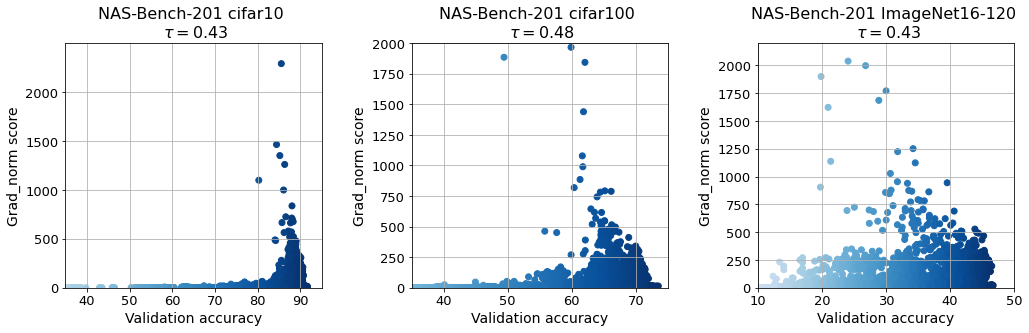

In [ ]:
ylabel = "Grad_norm score"
color_map = plt.get_cmap('Blues')
tau_cif10, _ = stats.kendalltau(cifar10_results_csv['gradNorm_score'], cifar10_results_csv['test_accuracy_200_epochs'])
tau_cif100, _ = stats.kendalltau(cifar100_results_csv['gradNorm_score'], cifar100_results_csv['test_accuracy_200_epochs'])
tau_ImNet, _ = stats.kendalltau(ImageNet16_120_results_csv['gradNorm_score'], ImageNet16_120_results_csv['test_accuracy_200_epochs'])

fig, ax = plt.subplots(1,3, figsize=figure_size, constrained_layout=True)
ax[0].scatter(cifar10_results_csv['validation_accuracy_200_epochs'], cifar10_results_csv['gradNorm_score'], c=cifar10_results_csv['validation_accuracy_200_epochs'], cmap=color_map, rasterized=True)
ax[0].set_xlim([35, 95])
ax[0].set_ylim([0, 2499])
ax[0].set_title(f"NAS-Bench-201 cifar10 \n $\\tau=${tau_cif10:.2f}", size=title_size)
ax[0].set_xlabel(xlabel, size=label_size)
ax[0].set_ylabel(ylabel, size=label_size)
ax[0].tick_params(axis='both', labelsize=tick_size)
ax[0].grid()

ax[1].scatter(cifar100_results_csv['validation_accuracy_200_epochs'], cifar100_results_csv['gradNorm_score'], c=cifar100_results_csv['validation_accuracy_200_epochs'], cmap=color_map, rasterized=True)
ax[1].set_xlim([35, 75])
ax[1].set_ylim([0, 2000])
ax[1].set_title(f"NAS-Bench-201 cifar100 \n $\\tau=${tau_cif100:.2f}", size=title_size)
ax[1].set_xlabel(xlabel, size=label_size)
ax[1].set_ylabel(ylabel, size=label_size)
ax[1].tick_params(axis='both', labelsize=tick_size)
ax[1].grid()

ax[2].scatter(ImageNet16_120_results_csv['validation_accuracy_200_epochs'], ImageNet16_120_results_csv['gradNorm_score'], c=ImageNet16_120_results_csv['validation_accuracy_200_epochs'], cmap=color_map, rasterized=True)
ax[2].set_xlim([10, 50])
ax[2].set_ylim([0, 2200])
ax[2].set_title(f"NAS-Bench-201 ImageNet16-120 \n $\\tau=${tau_ImNet:.2f}", size=title_size)
ax[2].set_xlabel(xlabel, size=label_size)
ax[2].set_ylabel(ylabel, size=label_size)
ax[2].tick_params(axis='both', labelsize=tick_size)
ax[2].grid()

plt.subplots_adjust(wspace=w_space)
plt.savefig("scatter_GradNor.svg", format='svg', dpi=650)

In [ ]:
# download graph
files.download('/content/scatter_GradNor.svg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Experiment: Spearman Correlation

In [ ]:
spearman_val = abs(stats.spearmanr(cifar10_results_csv['valid_accuracy_12_epochs'], cifar10_results_csv['test_accuracy_200_epochs'], nan_policy="omit").correlation)
spearman_relu = abs(stats.spearmanr(cifar10_results_csv['ReLU_score'], cifar10_results_csv['test_accuracy_200_epochs'], nan_policy="omit").correlation)
spearman_synflow = abs(stats.spearmanr(cifar10_results_csv['synflow_score'], cifar10_results_csv['test_accuracy_200_epochs']).correlation)
spearman_gradNorm = abs(stats.spearmanr(cifar10_results_csv['gradNorm_score'], cifar10_results_csv['test_accuracy_200_epochs'], nan_policy="omit").correlation)
sper_cif10 = [spearman_val, spearman_relu, spearman_synflow ,spearman_gradNorm]

spearman_val = abs(stats.spearmanr(cifar100_results_csv['valid_accuracy_12_epochs'], cifar100_results_csv['test_accuracy_200_epochs'], nan_policy="omit").correlation)
spearman_relu = abs(stats.spearmanr(cifar100_results_csv['ReLU_score'], cifar100_results_csv['test_accuracy_200_epochs'], nan_policy="omit").correlation)
spearman_synflow = abs(stats.spearmanr(cifar100_results_csv['synflow_score'], cifar100_results_csv['test_accuracy_200_epochs']).correlation)
spearman_gradNorm = abs(stats.spearmanr(cifar100_results_csv['gradNorm_score'], cifar100_results_csv['test_accuracy_200_epochs'], nan_policy="omit").correlation)
sper_cif100 = [spearman_val, spearman_relu, spearman_synflow ,spearman_gradNorm]

spearman_val = abs(stats.spearmanr(ImageNet16_120_results_csv['valid_accuracy_12_epochs'], ImageNet16_120_results_csv['test_accuracy_200_epochs'], nan_policy="omit").correlation)
spearman_relu = abs(stats.spearmanr(ImageNet16_120_results_csv['ReLU_score'], ImageNet16_120_results_csv['test_accuracy_200_epochs'], nan_policy="omit").correlation)
spearman_synflow = abs(stats.spearmanr(ImageNet16_120_results_csv['synflow_score'], ImageNet16_120_results_csv['test_accuracy_200_epochs']).correlation)
spearman_gradNorm = abs(stats.spearmanr(ImageNet16_120_results_csv['gradNorm_score'], ImageNet16_120_results_csv['test_accuracy_200_epochs'], nan_policy="omit").correlation)
sper_ImgNet = [spearman_val, spearman_relu, spearman_synflow ,spearman_gradNorm]

datasets = [sper_cif10, sper_cif100, sper_ImgNet]

sp_val = []
sp_relu = []
sp_synf = []
sp_gradNorm = []
for dataset in datasets:
  sp_val.append(dataset[0])
  sp_relu.append(dataset[1])
  sp_synf.append(dataset[2])
  sp_gradNorm.append(dataset[3])

In [ ]:
dic_tab = {'Dataset': ['CIFAR-10', 'CIFAR-100', 'ImageNet16-120'], 'val_acc': sp_val, 'ReLU': sp_relu, 'synflow': sp_synf, 'grad norm': sp_gradNorm} 
df_Spearman = pd.DataFrame(dic_tab)
df_Spearman.head()

,Dataset,val_acc,ReLU,synflow,grad norm
0,CIFAR-10,0.812472,0.781491,0.740042,0.593405
1,CIFAR-100,0.824764,0.810635,0.764763,0.640249
2,ImageNet16-120,0.818269,0.785685,0.752257,0.580684


Correlation with only the 10% best test accuracy  

In [17]:
cifar10_sort = pd.read_csv(r'/content/cifar10_results.csv', index_col=0)
cifar100_sort = pd.read_csv(r'/content/cifar100_results.csv', index_col=0)
ImageNet16_120_sort = pd.read_csv(r'/content/ImageNet16_120_results.csv', index_col=0)
tot_num_arc = cifar10_sort.shape[0]
perc_best = .1

cifar10_sort.sort_values(by=['valid_accuracy_12_epochs'], ascending=False, inplace=True)
cifar10_sort_cut = cifar10_sort.iloc[:(int)(tot_num_arc*perc_best)]  
spearman_val = abs(stats.spearmanr(cifar10_sort_cut['valid_accuracy_12_epochs'], cifar10_sort_cut['test_accuracy_200_epochs'], nan_policy="omit").correlation)
cifar10_sort.sort_values(by=['ReLU_score'], ascending=False, inplace=True)
cifar10_sort_cut = cifar10_sort.iloc[:(int)(tot_num_arc*perc_best)]  
spearman_relu = abs(stats.spearmanr(cifar10_sort_cut['ReLU_score'], cifar10_sort_cut['test_accuracy_200_epochs'], nan_policy="omit").correlation)
cifar10_sort.sort_values(by=['synflow_score'], ascending=False, inplace=True)
cifar10_sort_cut = cifar10_sort.iloc[:(int)(tot_num_arc*perc_best)]  
spearman_synflow = abs(stats.spearmanr(cifar10_sort_cut['synflow_score'], cifar10_sort_cut['test_accuracy_200_epochs']).correlation)
sper_cif10 = [spearman_val, spearman_relu, spearman_synflow]

cifar100_sort.sort_values(by=['valid_accuracy_12_epochs'], ascending=False, inplace=True)
cifar100_sort_cut = cifar100_sort.iloc[:(int)(tot_num_arc*perc_best)] 
spearman_val = abs(stats.spearmanr(cifar100_sort_cut['valid_accuracy_12_epochs'], cifar100_sort_cut['test_accuracy_200_epochs'], nan_policy="omit").correlation)
cifar100_sort.sort_values(by=['ReLU_score'], ascending=False, inplace=True)
cifar100_sort_cut = cifar100_sort.iloc[:(int)(tot_num_arc*perc_best)] 
spearman_relu = abs(stats.spearmanr(cifar100_sort_cut['ReLU_score'], cifar100_sort_cut['test_accuracy_200_epochs'], nan_policy="omit").correlation)
cifar100_sort.sort_values(by=['synflow_score'], ascending=False, inplace=True)
cifar100_sort_cut = cifar100_sort.iloc[:(int)(tot_num_arc*perc_best)] 
spearman_synflow = abs(stats.spearmanr(cifar100_sort_cut['synflow_score'], cifar100_sort_cut['test_accuracy_200_epochs']).correlation)
sper_cif100 = [spearman_val, spearman_relu, spearman_synflow]

ImageNet16_120_sort.sort_values(by=['valid_accuracy_12_epochs'], ascending=False, inplace=True)
ImageNet16_120_sort_cut = ImageNet16_120_sort.iloc[:(int)(tot_num_arc*perc_best)] 
spearman_val = abs(stats.spearmanr(ImageNet16_120_sort_cut['valid_accuracy_12_epochs'], ImageNet16_120_sort_cut['test_accuracy_200_epochs'], nan_policy="omit").correlation)
ImageNet16_120_sort.sort_values(by=['ReLU_score'], ascending=False, inplace=True)
ImageNet16_120_sort_cut = ImageNet16_120_sort.iloc[:(int)(tot_num_arc*perc_best)]
spearman_relu = abs(stats.spearmanr(ImageNet16_120_sort_cut['ReLU_score'], ImageNet16_120_sort_cut['test_accuracy_200_epochs'], nan_policy="omit").correlation)
ImageNet16_120_sort.sort_values(by=['synflow_score'], ascending=False, inplace=True)
ImageNet16_120_sort_cut = ImageNet16_120_sort.iloc[:(int)(tot_num_arc*perc_best)]
spearman_synflow = abs(stats.spearmanr(ImageNet16_120_sort_cut['synflow_score'], ImageNet16_120_sort_cut['test_accuracy_200_epochs']).correlation)
sper_ImgNet = [spearman_val, spearman_relu, spearman_synflow]

datasets = [sper_cif10, sper_cif100, sper_ImgNet]

sp_val = []
sp_relu = []
sp_synf = []
for dataset in datasets:
  sp_val.append(dataset[0])
  sp_relu.append(dataset[1])
  sp_synf.append(dataset[2])

In [18]:
dic_tab = {'Dataset': ['CIFAR-10', 'CIFAR-100', 'ImageNet16-120'], 'val_acc': sp_val, 'ReLU': sp_relu, 'synflow': sp_synf} 
df_Spearman = pd.DataFrame(dic_tab)
df_Spearman.head()

,Dataset,val_acc,ReLU,synflow
0,CIFAR-10,0.767169,0.188911,0.267266
1,CIFAR-100,0.721505,0.233171,0.306335
2,ImageNet16-120,0.756229,0.195365,0.186982


## Experiment: Tau Correlation

In [ ]:
tau_relu, _ = stats.kendalltau(cifar10_results_csv['ReLU_score'], cifar10_results_csv['test_accuracy_200_epochs'])
tau_synflow, _ = stats.kendalltau(cifar10_results_csv['synflow_score'], cifar10_results_csv['test_accuracy_200_epochs'])
tau_gradNorm, _ = stats.kendalltau(cifar10_results_csv['gradNorm_score'], cifar10_results_csv['test_accuracy_200_epochs'])
print(tau_relu, tau_synflow, tau_gradNorm)

tau_relu, _ = stats.kendalltau(cifar100_results_csv['ReLU_score'], cifar100_results_csv['test_accuracy_200_epochs'])
tau_synflow, _ = stats.kendalltau(cifar100_results_csv['synflow_score'], cifar100_results_csv['test_accuracy_200_epochs'])
tau_gradNorm, _ = stats.kendalltau(cifar100_results_csv['gradNorm_score'], cifar100_results_csv['test_accuracy_200_epochs'])
print(tau_relu, tau_synflow, tau_gradNorm)

tau_relu, _ = stats.kendalltau(ImageNet16_120_results_csv['ReLU_score'], ImageNet16_120_results_csv['test_accuracy_200_epochs'])
tau_synflow, _ = stats.kendalltau(ImageNet16_120_results_csv['synflow_score'], ImageNet16_120_results_csv['test_accuracy_200_epochs'])
tau_gradNorm, _ = stats.kendalltau(ImageNet16_120_results_csv['gradNorm_score'], ImageNet16_120_results_csv['test_accuracy_200_epochs'])
print(tau_relu, tau_synflow, tau_gradNorm)


0.5917957188301843 0.5434616170635638 0.43118517445931925
0.6257370845523986 0.569894973500337 0.475894186013805
0.6035782510817611 0.5616537288452873 0.4313541581567202


## Experiments: Table Graph and save over binary files

### Run Experiments and save over binary files: one for Random Search and one for  Evolution Search 

Random Serach parameters 

In [ ]:
dataset = 'cifar10' # dataset: string value choosen between { cifar10, cifar100, ImageNet16-120 }
n_arc_sample = 1000
number_experiments = 30

In [ ]:
rs_val_val12_mean, rs_val_val12_std, rs_test_val12_mean, rs_test_val12_std, rs_prog_val12, rs_time_val12 = run_random_search(datasets_dic[dataset], 'valid_accuracy_12_epochs', n=n_arc_sample, N=number_experiments)
rs_val_relu_mean, rs_val_relu_std, rs_test_relu_mean, rs_test_relu_std, rs_prog_relu, rs_time_relu = run_random_search(datasets_dic[dataset], 'ReLU_score', n=n_arc_sample, N=number_experiments)
rs_val_synf_mean, rs_val_synf_std, rs_test_synf_mean, rs_test_synf_std, rs_prog_synf, rs_time_synf = run_random_search(datasets_dic[dataset], 'synflow_score', n=n_arc_sample, N=number_experiments)
rs_val_gradNor_mean, rs_val_gradNor_std, rs_test_gradNor_mean, rs_test_gradNor_std, rs_prog_gradNor, rs_time_gradNor = run_random_search(datasets_dic[dataset], 'gradNorm_score', n=n_arc_sample, N=number_experiments)

rs_means = [rs_val_val12_mean, rs_val_relu_mean, rs_val_synf_mean, rs_val_gradNor_mean, rs_test_val12_mean, rs_test_relu_mean, rs_test_synf_mean, rs_test_gradNor_mean]
rs_stds = [rs_val_val12_std, rs_val_relu_std, rs_val_synf_std, rs_val_gradNor_std, rs_test_val12_std, rs_test_relu_std, rs_test_synf_std, rs_test_gradNor_std]
rs_progress = [rs_prog_val12, rs_prog_relu, rs_prog_synf, rs_prog_gradNor]
rs_time = [rs_time_val12, rs_time_relu, rs_time_synf, rs_time_gradNor]

rs_results = [dataset, rs_means, rs_stds, rs_progress, rs_time]

In [ ]:
# Save on binary file the results of the experiments with Random Search strategy
fp_rs = open('/content/random_results.data', 'wb')
pickle.dump(rs_results, fp_rs)
files.download('/content/random_results.data')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Evolution Search parameters

In [ ]:
dataset = 'cifar10' # dataset: string value choosen between { cifar10, cifar100, ImageNet16-120 }
max_trained_models = 1000
pool_size = 20
tournament_size = 10
number_experiments = 30

In [ ]:
ev_val_val12_mean, ev_val_val12_std, ev_test_val12_mean, ev_test_val12_std, ev_prog_val12, ev_time_val12 = run_evolution_search(datasets_dic[dataset], 'valid_accuracy_12_epochs', max_trained_models=max_trained_models, pool_size=pool_size, tournament_size=tournament_size, N=number_experiments)
ev_val_relu_mean, ev_val_relu_std, ev_test_relu_mean, ev_test_relu_std, ev_prog_relu, ev_time_relu  = run_evolution_search(datasets_dic[dataset], 'ReLU_score', max_trained_models=max_trained_models, pool_size=pool_size, tournament_size=tournament_size, N=number_experiments)
ev_val_synf_mean, ev_val_synf_std, ev_test_synf_mean, ev_test_synf_std, ev_prog_synf, ev_time_synf = run_evolution_search(datasets_dic[dataset], 'synflow_score', max_trained_models=max_trained_models, pool_size=pool_size, tournament_size=tournament_size, N=number_experiments)
ev_val_gradNor_mean, ev_val_gradNor_std, ev_test_gradNor_mean, ev_test_gradNor_std, ev_prog_gradNor, ev_time_gradNor = run_evolution_search(datasets_dic[dataset], 'gradNorm_score', max_trained_models=max_trained_models, pool_size=pool_size, tournament_size=tournament_size, N=number_experiments)

ev_means = [ev_val_val12_mean, ev_val_relu_mean, ev_val_synf_mean, ev_val_gradNor_mean, ev_test_val12_mean, ev_test_relu_mean, ev_test_synf_mean, ev_test_gradNor_mean]
ev_stds = [ev_val_val12_std, ev_val_relu_std, ev_val_synf_std, ev_val_gradNor_std, ev_test_val12_std, ev_test_relu_std, ev_test_synf_std, ev_test_gradNor_std]
ev_progress = [ev_prog_val12, ev_prog_relu, ev_prog_synf, ev_prog_gradNor]
ev_time = [ev_time_val12, ev_time_relu, ev_time_synf, ev_time_gradNor]

ev_results = [dataset, ev_means, ev_stds, ev_progress, ev_time]

In [ ]:
# Save on binary file the results of the experiments with Evolution Search strategy
fp_ev = open('/content/evolution_results.data', 'wb')
pickle.dump(ev_results, fp_ev)
files.download('/content/evolution_results.data')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Load results from binary files if you have just done the experiments and you only want to make plots and table

In [20]:
fp_rs = open('/content/random_results.data', 'rb')
rs_results = pickle.load(fp_rs)

dataset, rs_means, rs_stds, rs_progress, rs_time = rs_results[0], rs_results[1], rs_results[2], rs_results[3], rs_results[4]

rs_val_val12_mean, rs_val_val12_std, rs_test_val12_mean, rs_test_val12_std, rs_prog_val12, rs_time_val12 = rs_means[0], rs_stds[0], rs_means[4], rs_stds[4], rs_progress[0], rs_time[0]
rs_val_relu_mean, rs_val_relu_std, rs_test_relu_mean, rs_test_relu_std, rs_prog_relu, rs_time_relu =  rs_means[1], rs_stds[1], rs_means[5], rs_stds[5], rs_progress[1], rs_time[1]
rs_val_synf_mean, rs_val_synf_std, rs_test_synf_mean, rs_test_synf_std, rs_prog_synf, rs_time_synf = rs_means[2], rs_stds[2], rs_means[6], rs_stds[6], rs_progress[2], rs_time[2]
rs_val_gradNor_mean, rs_val_gradNor_std, rs_test_gradNor_mean, rs_test_gradNor_std, rs_prog_gradNor, rs_time_gradNor = rs_means[3], rs_stds[3], rs_means[7], rs_stds[7], rs_progress[3], rs_time[3]

In [21]:
fp_ev = open('/content/evolution_results.data', 'rb')
ev_results = pickle.load(fp_ev)

dataset, ev_means, ev_stds, ev_progress, ev_time = ev_results[0], ev_results[1], ev_results[2], ev_results[3], ev_results[4]

ev_val_val12_mean, ev_val_val12_std, ev_test_val12_mean, ev_test_val12_std, ev_prog_val12, ev_time_val12 = ev_means[0], ev_stds[0], ev_means[4], ev_stds[4], ev_progress[0], ev_time[0]
ev_val_relu_mean, ev_val_relu_std, ev_test_relu_mean, ev_test_relu_std, ev_prog_relu, ev_time_relu =  ev_means[1], ev_stds[1], ev_means[5], ev_stds[5], ev_progress[1], ev_time[1]
ev_val_synf_mean, ev_val_synf_std, ev_test_synf_mean, ev_test_synf_std, ev_prog_synf, ev_time_synf = ev_means[2], ev_stds[2], ev_means[6], ev_stds[6], ev_progress[2], ev_time[2]
ev_val_gradNor_mean, ev_val_gradNor_std, ev_test_gradNor_mean, ev_test_gradNor_std, ev_prog_gradNor, ev_time_gradNor = ev_means[3], ev_stds[3], ev_means[7], ev_stds[7], ev_progress[3], ev_time[3]

### Results table

In [32]:
data = [[f'{rs_time_val12:.1f}',f'{rs_val_val12_mean:.2f}±{rs_val_val12_std:.2f}',f'{rs_test_val12_mean:.2f}±{rs_test_val12_std:.2f}',f'{ev_time_val12:.1f}',f'{ev_val_val12_mean:.2f}±{ev_val_val12_std:.2f}',f'{ev_test_val12_mean:.2f}±{ev_test_val12_std:.2f}'],
        [f'{rs_time_relu:.1f}',f'{rs_val_relu_mean:.2f}±{rs_val_relu_std:.2f}',f'{rs_test_relu_mean:.2f}±{rs_test_relu_std:.2f}',f'{ev_time_relu:.1f}',f'{ev_val_relu_mean:.2f}±{ev_val_relu_std:.2f}',f'{ev_test_relu_mean:.2f}±{ev_test_relu_std:.2f}'],
        [f'{rs_time_synf:.1f}',f'{rs_val_synf_mean:.2f}±{rs_val_synf_std:.2f}',f'{rs_test_synf_mean:.2f}±{rs_test_synf_std:.2f}',f'{ev_time_synf:.1f}',f'{ev_val_synf_mean:.2f}±{ev_val_synf_std:.2f}',f'{ev_test_synf_mean:.2f}±{ev_test_synf_std:.2f}'],
        [f'{rs_time_gradNor:.1f}',f'{rs_val_gradNor_mean:.2f}±{rs_val_gradNor_std:.2f}',f'{rs_test_gradNor_mean:.2f}±{rs_test_gradNor_std:.2f}',f'{ev_time_gradNor:.1f}',f'{ev_val_gradNor_mean:.2f}±{ev_val_gradNor_std:.2f}',f'{ev_test_gradNor_mean:.2f}±{ev_test_gradNor_std:.2f}']]

In [33]:
cols_name = [['Random Search', 'Random Search', 'Random Search', 'Evolutionary', 'Evolutionary', 'Evolutionary'], ['time', 'validation', 'test', 'time', 'validation', 'test']]
metrics_name = ['val_acc', 'ReLU', 'synflow', 'grad norm']

In [34]:
from pyparsing.util import col
df_results = pd.DataFrame(data, index=metrics_name, columns=cols_name)
df_results.head()

Random Search                         Evolutionary              \
                   time  validation        test         time  validation   
val_acc        147867.9  91.36±0.18  91.11±0.22     186277.0  91.32±0.26   
ReLU               84.9  89.98±0.44  89.70±0.44        198.1  90.21±0.11   
synflow            77.9  89.93±0.87  89.69±0.87        102.0  90.20±0.00   
grad norm          87.2  86.73±2.52  86.29±2.57         98.9  85.51±0.00   

                       
                 test  
val_acc    91.00±0.24  
ReLU       89.89±0.20  
synflow    90.22±0.00  
grad norm  85.12±0.00

### Graphs: Search Progress

Plot the Search progress:

In [35]:
a = np.array([1,2,3])
b = np.array([10,20,30])
c=a+b
c

array([11, 22, 33])

In [36]:
def plot_experiment(exp_list, title):
  fig, ax = plt.subplots(figsize=(6,6), constrained_layout=True)
  def plot_exp(exp, label):
    exp = np.array(exp) 
    q_75 = np.quantile(exp, .75, axis=0)
    q_25 = np.quantile(exp, .25, axis=0)
    mean = np.mean(exp, axis=0)
    
    ax.plot(mean, label=label)
    ax.fill_between(range(len(q_25)), q_25, q_75, alpha=0.1)
  for exp,ename in exp_list:
    plot_exp(exp,ename)
  ax.set_title(title, size=16)
  ax.grid() 
  ax.set_xlabel('Scored Models', size=14)
  ax.set_ylabel('Test Accuracy', size=14)
  ax.set_xlim([0, 1000])
  ax.tick_params(axis='both', labelsize=13)
  ax.legend(fontsize=13)
  plt.savefig(f"{title}.svg", format='svg')

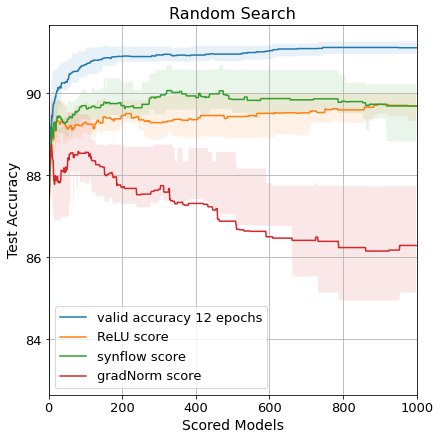

In [37]:
# Polot Random Search progress
plot_experiment([(rs_prog_val12,'valid accuracy 12 epochs'), (rs_prog_relu, 'ReLU score'), (rs_prog_synf, 'synflow score'), (rs_prog_gradNor, 'gradNorm score')], 'Random Search')


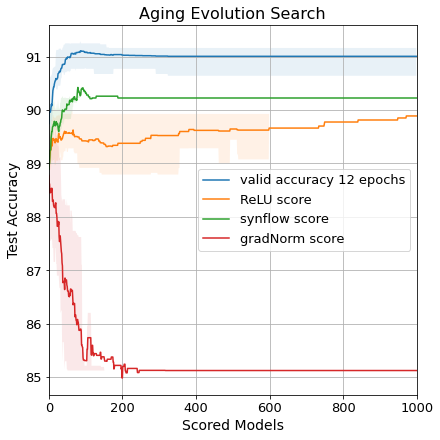

In [38]:
# Plot Aging Evolution progress
plot_experiment([(ev_prog_val12,'valid accuracy 12 epochs'), (ev_prog_relu, 'ReLU score'), (ev_prog_synf, 'synflow score'), (ev_prog_gradNor, 'gradNorm score')], 'Aging Evolution Search')


In [ ]:
# download progress graphs
files.download('/content/Random Search.svg')
files.download('/content/Aging Evolution Search.svg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>